# Simple Row-Aggregating Features With Stacking In The Movielens Dataset 

This example illustrates using `pandas`-munging capabilities in estimators building features that draw from several rows. We will use a single table from the [Movielens dataset](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)).

## Loading The Data

In this example, we'll only use the dataset table describing the ratings themselves. I.e., each row is an instance of a single rating given by a specific user to a specific movie.

In [56]:
import os

from sklearn import base
from scipy import stats
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import linear_model as pd_linear_model
from ibex.xgboost import XGBRegressor as PdXGBRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [57]:
ratings = pd.read_csv(
    '../movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
features = ['user_id', 'item_id']
ratings = ratings.sample(frac=1)
ratings[features + ['rating']].head()

,user_id,item_id,rating
93189,885,290,1
66432,445,1047,1
21435,368,89,4
30289,370,484,4
6716,346,245,4


## dd 

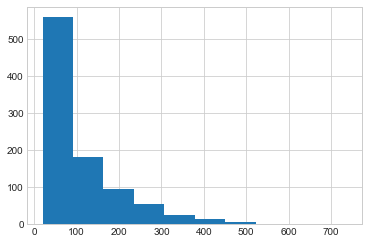

In [87]:
hist(ratings.user_id.groupby(ratings.user_id).count().values);

In [109]:
def sample_group(g):
    p, max_ = 0.5, 200
    num = stats.binom.rvs(min(len(g), max_), p, size=1)[0]
    frac = float(num) / len(g)
    return g.sample(frac=frac)


reduced_ratings = ratings.groupby(ratings.user_id, as_index=False).apply(sample_group)
reduced_ratings.index = reduced_ratings.index.levels[1]
reduced_ratings = reduced_ratings.sample(frac=1)
reduced_ratings.head()

,user_id,item_id,rating,timestamp
81504,760,451,5,875668781
29302,280,210,2,891700385
13113,121,298,2,891388676
4862,44,95,4,878347569
40593,373,1147,4,877104115


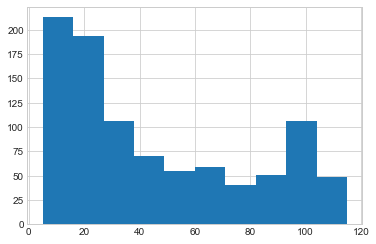

In [110]:
hist(reduced_ratings.user_id.groupby(reduced_ratings.user_id).count().values);

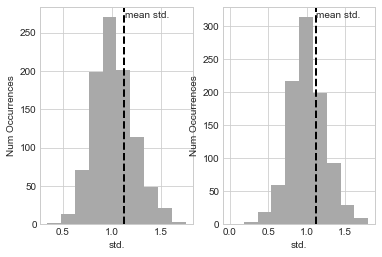

In [111]:
subplot(1, 2, 1)
by_user_std = ratings.rating.groupby(ratings.user_id).std()
axvline(
    ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

subplot(1, 2, 2)
by_user_std = reduced_ratings.rating.groupby(reduced_ratings.user_id).std()
axvline(
    reduced_ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * reduced_ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

## Stacking Using Pandas

Unsuprisingly, the results are even worse than before. Methodically, this is the correct way of building the feature without peeking, and so the CV result should intuitively be weaker.

In [3]:
ratings[ratings.user_id == 1]

,user_id,item_id,rating,timestamp
85377,1,244,2,887431973
34550,1,268,5,875692927
62631,1,4,3,876893119
7180,1,51,4,878543275
87831,1,18,4,887432020
81568,1,83,3,875072370
2328,1,64,5,875072404
8745,1,259,1,875692979
84793,1,207,5,875073067
9255,1,44,5,878543541


In [4]:
user_rating_stats = \
    ratings.rating.groupby(ratings.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})
user_rating_stats.head()

,user_id_sum,user_id_count
user_id,,
1,982,272
2,230,62
3,151,54
4,104,24
5,503,175


In [5]:
user_ratings = pd.merge(
    ratings[['user_id', 'rating']],
    user_rating_stats,
    left_on='user_id',
    right_index=True,
    how='left')
user_ratings.head()

,user_id,rating,user_id_sum,user_id_count
64953,773,5,528,161
24115,407,5,784,226
40336,593,3,563,156
12643,234,3,1499,480
43824,262,3,507,160


In [6]:
user_ratings[user_ratings.user_id == 1]

,user_id,rating,user_id_sum,user_id_count
85377,1,2,982,272
34550,1,5,982,272
62631,1,3,982,272
7180,1,4,982,272
87831,1,4,982,272
81568,1,3,982,272
2328,1,5,982,272
8745,1,1,982,272
84793,1,5,982,272
9255,1,5,982,272


In [7]:
user_ratings.user_id_count -= 1
user_ratings['user_id_mean'] = np.where(
    user_ratings.user_id_count == 0,
    -1,
    (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)

In [8]:
user_ratings.head()

,user_id,rating,user_id_sum,user_id_count,user_id_mean
64953,773,5,528,160,3.268750
24115,407,5,784,225,3.462222
40336,593,3,563,155,3.612903
12643,234,3,1499,479,3.123173
43824,262,3,507,159,3.169811


In [9]:
user_ratings[user_ratings.user_id == 1]

,user_id,rating,user_id_sum,user_id_count,user_id_mean
85377,1,2,982,271,3.616236
34550,1,5,982,271,3.605166
62631,1,3,982,271,3.612546
7180,1,4,982,271,3.608856
87831,1,4,982,271,3.608856
81568,1,3,982,271,3.612546
2328,1,5,982,271,3.605166
8745,1,1,982,271,3.619926
84793,1,5,982,271,3.605166
9255,1,5,982,271,3.605166


## Building A Pandas-Munging Stacking Estimator

We'll now use Pandas to build a feature building these features. 

* For each movie, we'll store the mean score & number of occurrences.

* For each user, we'll store the mean score & number of occurrences.

In [20]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        return self
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        
        user_rating_stats = \
            y.groupby(X.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})        
        X = pd.concat([X['user_id'], y], axis=1)
        X.columns = ['user_id', 'rating']
        user_ratings = pd.merge(
            X,
            user_rating_stats,
            left_on='user_id',
            right_index=True,
            how='left')
        user_ratings.user_id_count -= 1
        user_ratings['user_id_mean'] = np.where(
            user_ratings.user_id_count == 0,
            -1,
            (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)
        
        return user_ratings[['user_id_mean', 'user_id_count']]
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings

In [21]:
f = ScoresAggregator()

In [22]:
f.fit_transform(ratings[features], ratings.rating)

,user_id_mean,user_id_count
64953,3.268750,160
24115,3.462222,225
40336,3.612903,155
12643,3.123173,479
43824,3.169811,159
40654,3.533724,341
68405,3.362319,483
64528,2.907895,684
27471,3.834197,193
7001,3.725490,153


In [ ]:
prd = ScoresAggregator() | PdXGBRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=20, n_jobs=-1),
    color='darkgrey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');

The CV histogram indicates that the results are now positive.

In [20]:
prd.fit(ratings[features], ratings.rating).score(ratings[features], ratings.rating)

[[ 1.          0.99949012]
 [ 0.99949012  1.        ]]


-0.29483564792718364

In [22]:
plot(
    ratings.rating,
    prd.fit(ratings[features], ratings.rating).predict(ratings[features]),
    '+');

[[ 1.          0.99949012]
 [ 0.99949012  1.        ]]


In [19]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self.x_columns = X
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        return self
    
    def fit_transform(self, X, y):
        user_rating_stats = \
            y.groupby(X.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})        
        X_ = pd.concat([X['user_id'], y], axis=1)
        X_.columns = ['user_id', 'rating']
        user_ratings = pd.merge(
            X_,
            user_rating_stats,
            left_on='user_id',
            right_index=True,
            how='left')
        user_ratings.user_id_count -= 1
        user_ratings['user_id_mean'] = np.where(
            user_ratings.user_id_count == 0,
            -1,
            (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)
        
        print(
            np.corrcoef(user_ratings.user_id_mean, self.fit(X, y).transform(X).user_id_mean))
        
        self.fit(X, y)
        
        # return self.fit(X, y).transform(X)
        print(user_ratings.columns)
        return user_ratings[['user_id_mean', 'user_id_count']]
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        print(user_ratings.columns)
        return user_ratings
    
prd = ScoresAggregator() | PdXGBRegressor()
prd.fit(ratings[features], ratings.rating).score(ratings[features], ratings.rating)

Index(['user_id_mean', 'user_id_count'], dtype='object')
[[ 1.          0.99949012]
 [ 0.99949012  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id_mean', 'user_id_count'], dtype='object')


0.15395558004247123